In [1]:
!python --version

Python 3.10.1


## Step 1: Import necessary libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

sns.set_context("notebook")

sns.set_theme(style="ticks")

## Step 2: Load the dataset

In [3]:
# input_file_path = "..\\data\\heart_disease_health_indicators_BRFSS2015.csv"
input_file_path = "https://raw.githubusercontent.com/kaidalisohaib/AICohortW24/main/data/heart_disease_health_indicators_BRFSS2015.csv"

df = pd.read_csv(input_file_path, header = 0)

df.head()

all_columns = df.columns.tolist()

# Define target column
target_column = "HeartDiseaseorAttack"

# Get all feature columns except one
all_features = all_columns
all_features.remove(target_column)

# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get non-numerical (categorical) columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("All the columns:\n", all_columns)
print("Target column:\n", target_column)
print("Features columns:\n", all_features) 
print("Numerical Columns:\n",numerical_cols)
print("Categorical Columns:\n",categorical_cols)


All the columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Target column:
 HeartDiseaseorAttack
Features columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Numerical Columns:
 ['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Categorical Columns:
 []


## Step 3: Data exploration

### 3.1 Descriptive Statistics

In [4]:
# Print the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Get summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
print(df.describe())

# Get the count of unique values in each column
print("\nCount of unique values in each column:")
print(df.nunique())

print("\nCount of missing values:")
print(df.isnull().sum())

# Get the count of duplicate rows
print("\nCount of duplicated rows:")
print(df.duplicated(keep=False).sum())

# Value counts of a numerical variable
print("\nValue counts of a numerical variable:")
print(len(numerical_cols))

# Value counts of a categorical variable
print("\nValue counts of a categorical variable:")
print(len(categorical_cols))

First few rows of the dataset:
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  Di

### 3.2 Data Visualization

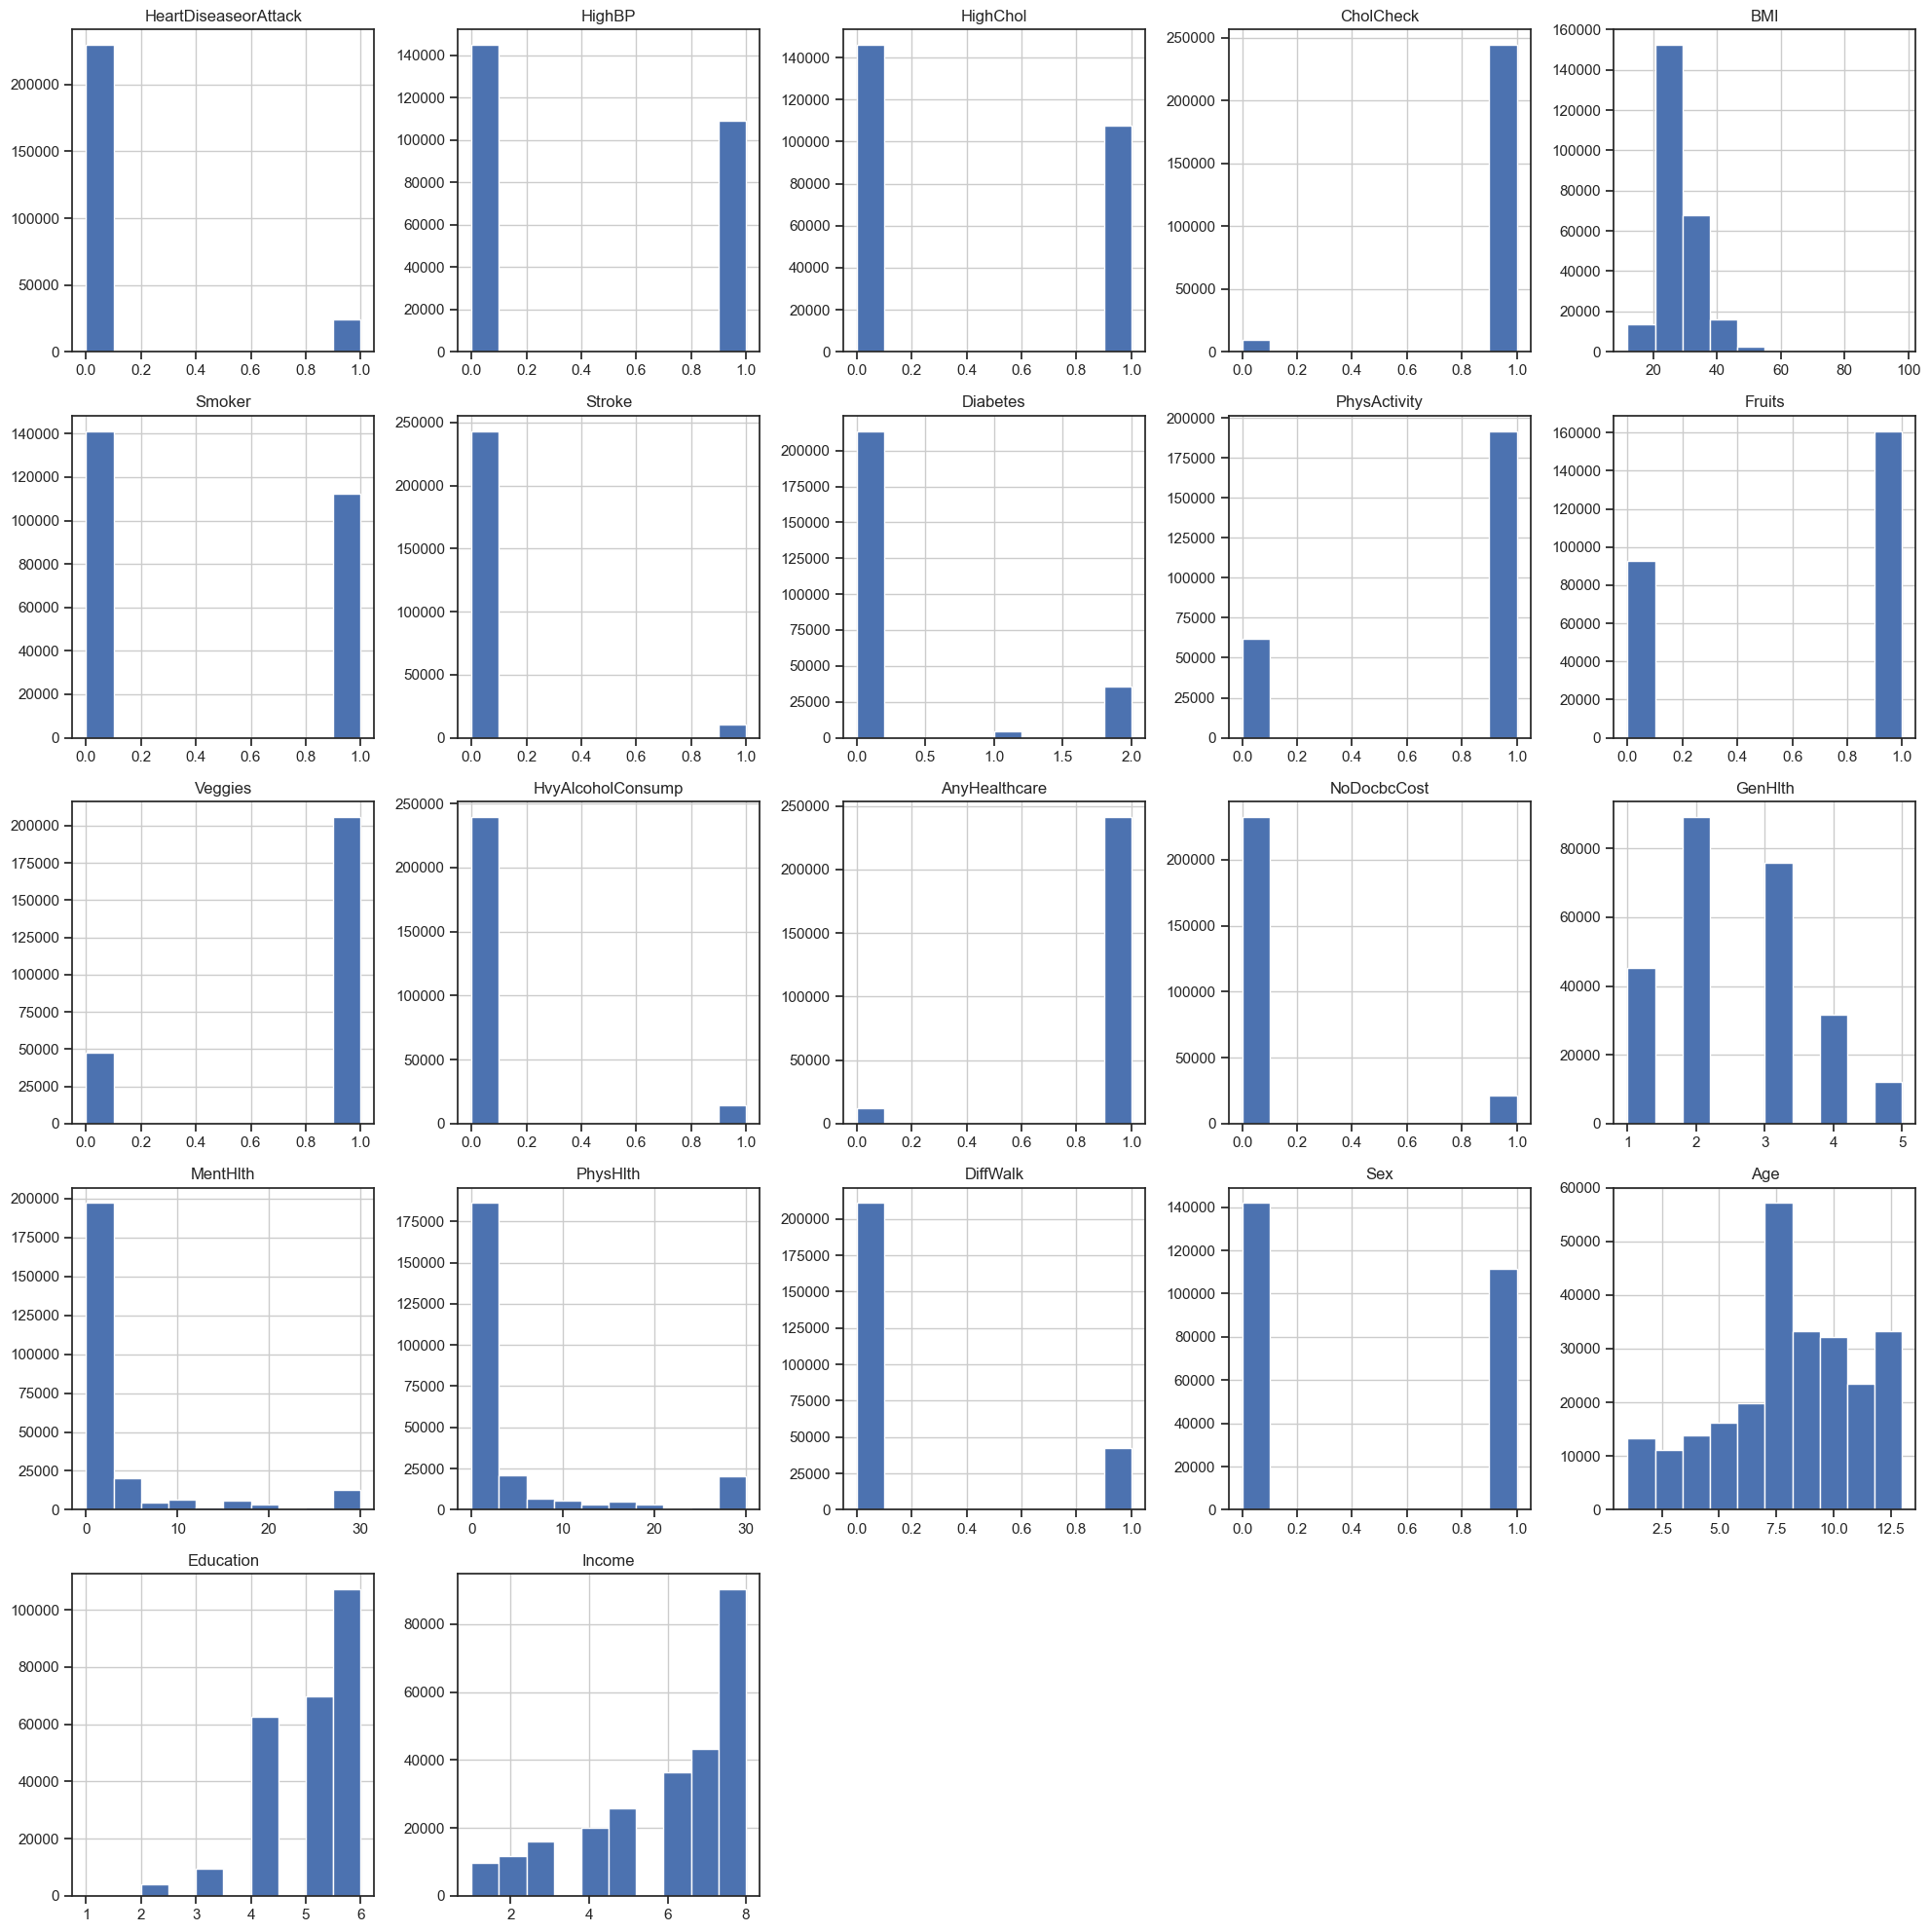

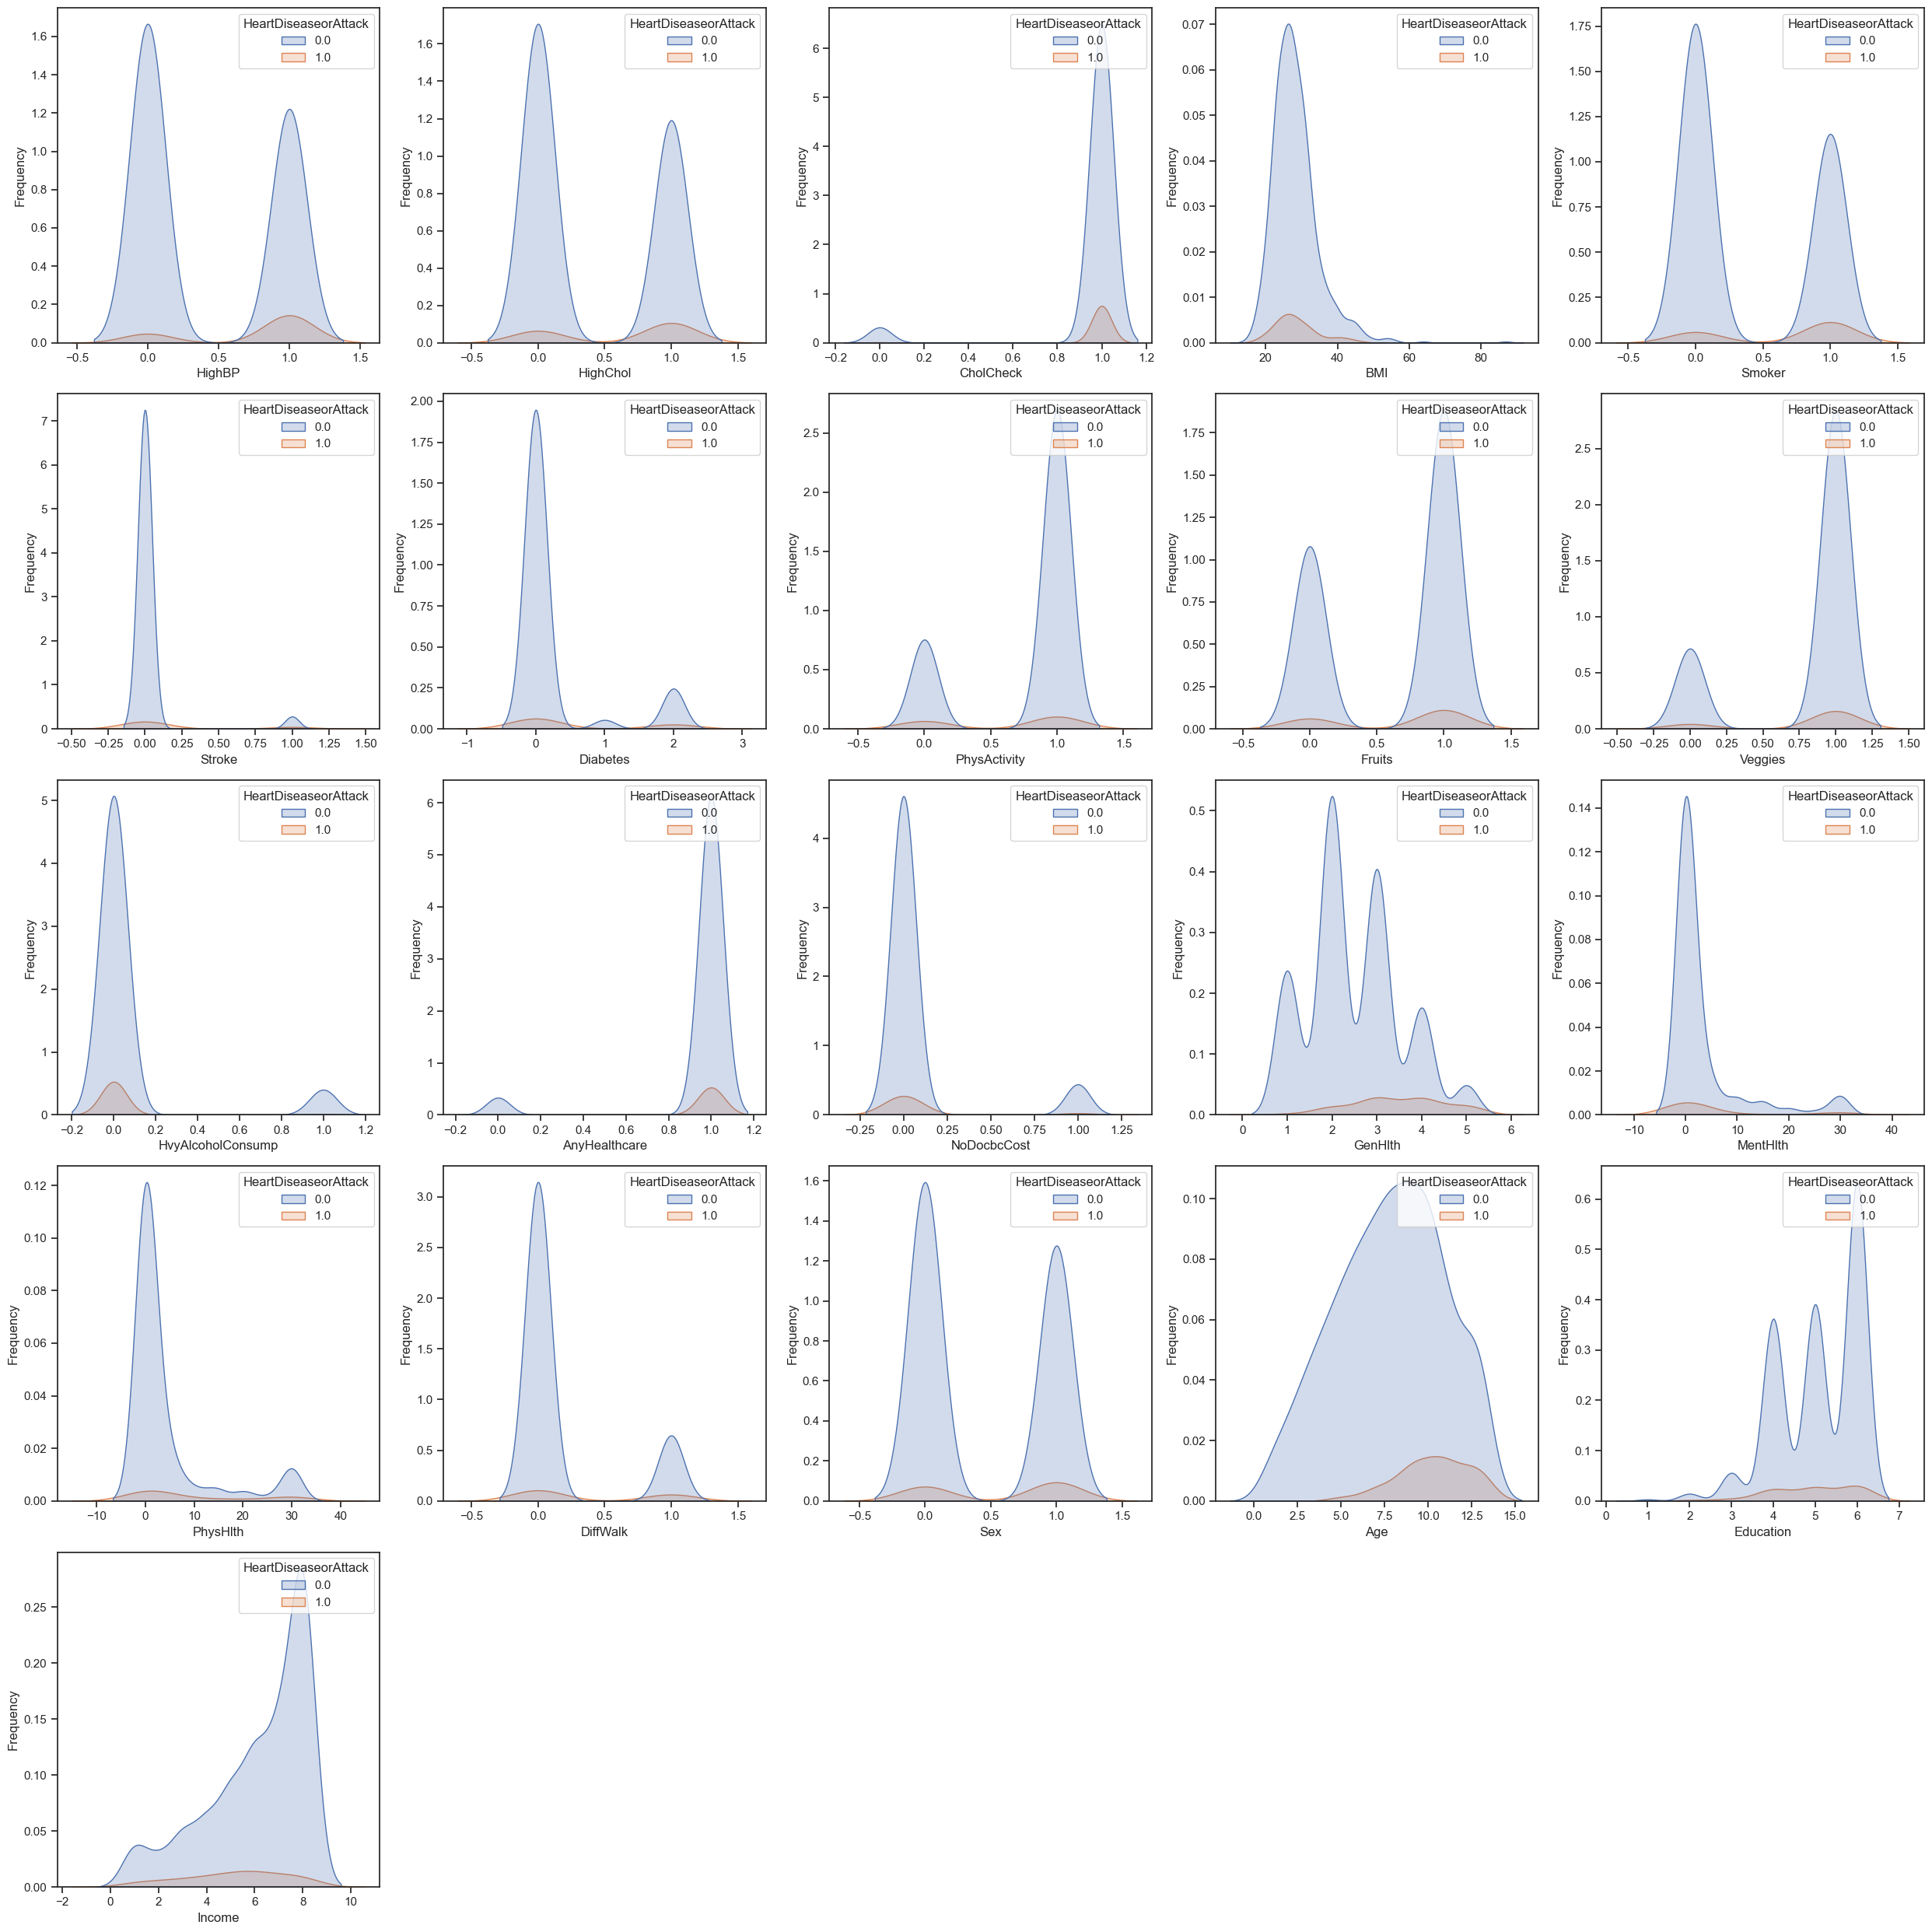

In [5]:
sample_df = df.sample(1_000)

df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

###########

# Determine the number of columns in the pairplot grid
num_cols = 5  # Adjust the number of columns as needed

# Calculate the number of rows needed for the pairplot grid
num_rows = (len(all_features) + num_cols - 1) // num_cols

# Create a single figure and axes for the pairplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

# Plot each feature against the target variable
for i, feature in enumerate(all_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.kdeplot(data=sample_df, x=feature, hue=target_column, fill=True, ax=ax)
    ax.set_ylabel("Frequency")

# Hide empty subplots
for i in range(len(all_features), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Show the combined pairplot image
plt.tight_layout()
plt.show()

### 3.3 Pattern identification

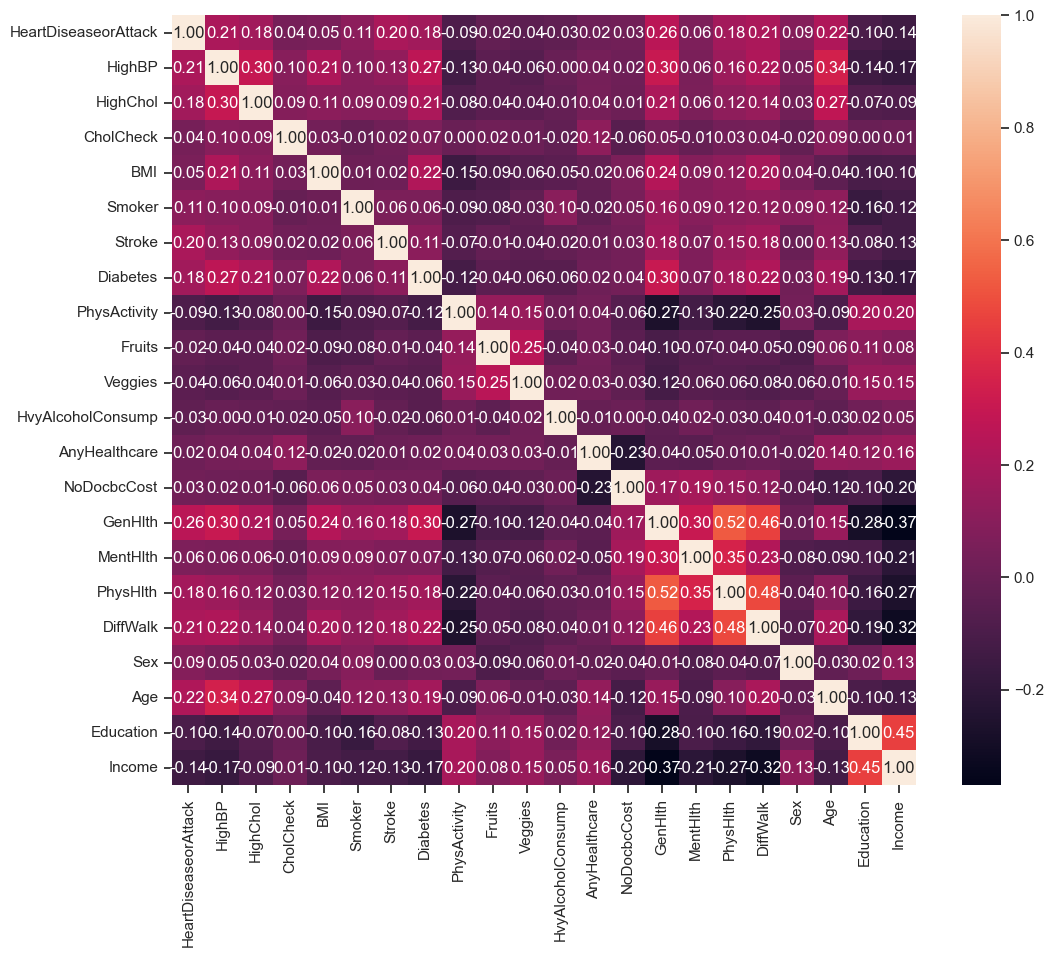

In [6]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## Step 4: Data preprocessing
TODO: Handle missing values, encode categorical variables, perform feature scaling, etc.

In [7]:
df.drop_duplicates(keep='first', inplace=True)
# No missing value so we're good

## Step 5: Data visualization
TODO: Visualize the data to gain insights (e.g., histograms, scatter plots, correlation matrix)

## Step 6: Split the dataset into train and test sets

## Step 7: Feature scaling

## Step 8: Model training

## Step 9: Model evaluation

## Step 10: Confusion matrix

## Step 11: Classification report